In [1]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random


In [2]:
#Defining constants
Plapse=0.15;#Probability of lapsing in a given year
EQ0=80000;#Starting base equity
PR0=20000;#Starting base propriety investment
C0=100000;#C0
seq=0.2;#Volatility of equity
spr=0.1;#Volatility of propriety
RD=0.022;#Regular deductions
COMM=0.014;#Commissions to the distribution channel
Inflation=0.02;#Inflation rate
symmetric_adjustment=0.0525;#Symmetric adjustment (from EIOPA)
future_expenses=50; #Future expecetd expenses for each year
uni=np.linspace(0,50,51)

In [3]:
#Function to simulate GBM paths
#Inputs
#r = forward rate vector for each yeas
#sigma = volatility 
#S0 = starting value
#n = number of simulations to perform
#Output
#The Output is a matrix containing on each row a simulated path
def SimulateGBM (r,sigma,S0,n):
    S=np.zeros([n,len(r)+1])
    Z = np.random.normal(0,1,[n,len(r)+1])
    S[:,0]=np.ones(n)*S0;
    for i in range(len(r)):
        #A[i+1]=A[i]+(r[i+1]*S[i])+sigma*A[i]*(Z[i+1])
        S[:,i+1]=S[:,i]*np.exp((r[i]-(sigma*sigma)/2)+sigma*Z[:,i])
    return S;

In [4]:
#Import Data from EIOPA for the Interest 
#rates and for the Stressed scenarios
data = pd.read_excel("EIOPA_RFR_20240331_Term_Structures.xlsx","RFR_spot_no_VA",header=1)
dataup = pd.read_excel("EIOPA_RFR_20240331_Term_Structures.xlsx","Spot_NO_VA_shock_UP",header=1)
datadown = pd.read_excel("EIOPA_RFR_20240331_Term_Structures.xlsx","Spot_NO_VA_shock_DOWN",header=1)

##Here I take the Eiopa rates for the
#intersted period (50 years) and put them in numpy vectors
#Un-Stressed interest rates 
data=data.drop(data.index[0:7])
EIOPA_rates=data["Italy"].to_numpy()
EIOPA_rates[0]=0
EIOPA_rates=EIOPA_rates[0:51]

#Stressed-up interest rates 

dataup=dataup.drop(dataup.index[0:7])
EIOPA_rates_up=dataup["Italy"].to_numpy()
EIOPA_rates_up[0]=0
EIOPA_rates_up=EIOPA_rates_up[0:51]


#Stressed-down interest rates

datadown=datadown.drop(datadown.index[0:7])
EIOPA_rates_down=datadown["Italy"].to_numpy()
EIOPA_rates_down[0]=0
EIOPA_rates_down=EIOPA_rates_down[0:51]

##Here I transform the spot rates in exponential capitalization
##than compute the Discounts and the Forward rates for GBM simulation

#Base-Rates
Variabile_Temporanea=EIOPA_rates+1
Spot=Variabile_Temporanea.tolist()
Spot=np.log(Spot)
uni=np.linspace(0,50,51)
Discounts=np.exp(-Spot*uni)
Forward=-np.log(Discounts[1:]/Discounts[0:-1])

#Stressed-Up Case
Variabile_Temporanea=EIOPA_rates_up+1
Spot_up=Variabile_Temporanea.tolist()
Spot_up=np.log(Spot_up)
uni=np.linspace(0,50,51)
Discounts_up=np.exp(-Spot_up*uni)
Forward_up=-np.log(Discounts_up[1:]/Discounts_up[0:-1])

#Stressed-Down Case
Variabile_Temporanea=EIOPA_rates_down+1
Spot_down=Variabile_Temporanea.tolist()
Spot_down=np.log(Spot_down)
uni=np.linspace(0,50,51)
Discounts_down=np.exp(-Spot_down*uni)
Forward_down=-np.log(Discounts_down[1:]/Discounts_down[0:-1])

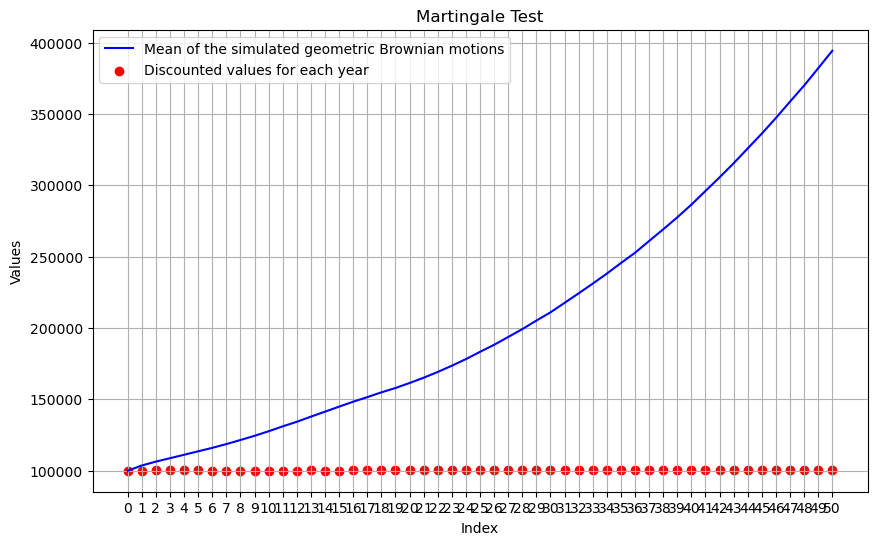

In [5]:
#Martingale test
M=10000000;
Eqt=SimulateGBM(Forward,seq,EQ0,M)
Prt=SimulateGBM(Forward,spr,PR0,M)
Ft=Eqt+Prt

Ft_mean=np.mean(Ft,axis=0)
np.shape(Ft_mean)
Ft_mean_Discounted=Ft_mean*Discounts

x = np.arange(51)

plt.figure(figsize=(10, 6))
plt.plot(x, Ft_mean, label='Mean of the simulated geometric Brownian motions',
linestyle='-', color='blue')
plt.scatter(x, Ft_mean_Discounted, 
label='Discounted values for each year', color='red')
plt.title('Martingale Test')
plt.xlabel('Index')
plt.ylabel('Values')
plt.xticks(x)  
plt.legend()
plt.grid(True)
plt.show()





In [6]:
#Import Life Table data from Istat and convert them to numpy vectors
life_table=pd.read_excel("Life tables of the resident population (1).xlsx","Sheet2")
life_table=life_table[0:51]
qx=life_table["qx"].to_numpy()
px=life_table["px"].to_numpy()
px_cumulative=life_table["px_cumulative"].to_numpy()

In [7]:
#This Function computes the BEL in all its PV components, it also computes the Macaulay duration of the liabilities,
#and the total liabilities.
#These computation are performed for each simulation and then averaged.
#This funciton will perform the computation for the base case as well as all stressed cases
#M=number of simulations, N= time-steps
#INPUTS:
#Ft = evolution of the fund for each simulation [M*N] 
#qx = probability of death during the year x
#px_cumulative = probability of survival up to the compleation of year x
#Plapse = probability of lapsing for each year
#Inflation = Inflation rate
#Discounts = Discounts vecotr as function of time
#COMM = Commissions to the distribution channel
#Future_expenses = value of the future expenses for the following years
#Lapse_mass = Flag value to perform the computation under the stress scenario (=1 if stree, =0 if non stress)
#RD= Regular Deductions
#flag_base a flag variable to modify the output
#Outputs:
#BOF = BOF
def ComputeLiabilities(Ft,qx,px_cumulative,Plapse,Inflation,Discounts,COMM,Future_Expenses,Lapse_mass,RD,flag_base):
    random.seed(42)
    uni=np.linspace(0,50,51)
    ##Here we compute the probabilities of exiting out of the contract due to lapse we assume that an individual
    ##may decide to lapse in a year, but than lapses at the end of the year, therefor in the event that an individual
    ##decides to lapse in the same year in wich he dies the death "takes priority" 
    #Check if we are in stress case

    if Lapse_mass==1:
    #If yes we increase by 0.4 the probability of lapsing for the first year
        p_lapse=np.zeros(51)
        p_lapse[0]=px_cumulative[0]*(Plapse+0.4)
        p_lapse[1:]=px_cumulative[1:]*((1-Plapse)**(uni[1:]-1))*Plapse*(1-Plapse-0.4)
    else:
    #If not we don't 
        p_lapse=px_cumulative*((1-Plapse)**(uni))*Plapse
    

    
    #Compute the probabilities of exiting out of the contract due to death
    px_cumulative_shfited=np.concatenate((np.array([1]),px_cumulative))[:-1]
    p_death=px_cumulative_shfited*(1-(Plapse+Lapse_mass*0.4))*((1-Plapse)**(uni))*qx/(1-Plapse);
    p_death[0]=qx[0];
    #p_death=np.zeros(51);
    #p_death[1]=qx[1]*px_cumulative[0]*(1-(Plapse+Lapse_mass*0.4)) 
    p_in_contract=(1-(Plapse+Lapse_mass*0.4))*np.ones(51)*((1-Plapse)**(uni+1))*np.cumprod(1-qx)/(1-Plapse)




    
    ##Computation of benefits and expenses#
    #Computation Benefits in case of Lapse
    BenefitsLapse=(Ft-20)
    #Computation Benefits in case of death
    BenfitsDeath=np.maximum(Ft,C0*np.ones((len(Ft),51)))
    #Computation expenses
    Expenses=Future_Expenses*np.ones(51)*((1+Inflation)**uni)
    
    
    ##Computation of the liabilities, here we deduct the Regular deductions 
    #Liabilitis in case of lapse
    LapseLiabilities=BenefitsLapse*p_lapse*Discounts
    #Liabilitis in case of death
    DeathLiabilities=BenfitsDeath*p_death*Discounts
    #Commission Liabilities (ATTENZIONE QUA PENSI DI DOVER CAMBIARE CON LA MODIFICA MESSA COOME COMMENTO A SINISTRA)
    #CommissionLiabilities=COMM*(LapseLiabilities+DeathLiabilities)# /(1-RD)
    CommissionLiabilities=(Ft[:,1:]/(1-RD))*COMM*p_in_contract[0:-1]*Discounts[1:]
    CommissionLiabilities = np.insert(CommissionLiabilities, 0, 0, axis=1)
    #Expense Liabilities
    #Old ExpenseLiabilities=Expenses*Discounts*px_cumulative*((1-Plapse)**uni)
    ExpenseLiabilities=Expenses*Discounts*np.insert(p_in_contract, 0, 1)[:-1]

    
    
    #Compute total liabilitis, this is a vector containing all the expected actualized future liabilities for each year
    #And for each simulation
    Total_Liabilities=LapseLiabilities+DeathLiabilities+CommissionLiabilities+ExpenseLiabilities

    #We take the mean of those expected liabilities among all simulations
    Total_Liabilities2=np.mean(Total_Liabilities,axis=0)
    #We compute the duration using the previously computed vector
    Duration=np.sum(Total_Liabilities2*np.linspace(0,50,51))/(np.sum(Total_Liabilities2))
    ##Compute the BEL for each simulation
    Bel_Lapse_each=np.sum(LapseLiabilities,axis=1)
    Bel_Death_each=np.sum(DeathLiabilities,axis=1)
    Bel_expenses=np.sum(ExpenseLiabilities)
    Bel_commissions_each=np.sum(CommissionLiabilities,axis=1)
    ##Compute the mean among all simulations (for expenses it's not necessary since it's the same for all simulations)
    Bel_Lapse=np.mean(Bel_Lapse_each)
    Bel_Death=np.mean(Bel_Death_each)
    Bel_commissions=np.mean(Bel_commissions_each)    
    #Compute total liabilities as a sum of all the BEL
    Tot_lia=Bel_Lapse+Bel_Death+Bel_expenses+Bel_commissions
    #Compute BOF
    BOF=Ft[0][0]-Tot_lia
    if(flag_base==1):
        return BOF,Duration,Tot_lia,Bel_Lapse,Bel_Death,Bel_commissions,Bel_expenses
    else:
        return BOF,Duration,Tot_lia

In [161]:
###Base case and stress with simulations###

M=10000000;#nuumber of  simulations
random.seed(42)
Deductions=((1-RD))**uni
##Now we compute the values for each case using the
#function above, the main point is 
#that we need to change the inputs 
#in order to apply the various cases,
#having done that the computations do not change
#Base
Eqt=SimulateGBM(Forward,seq,EQ0,M)*Deductions
Prt=SimulateGBM(Forward,spr,PR0,M)*Deductions
Ft=Eqt+Prt
BOF_base,Duration_base,Bel_base,Bel_Lapse_base,Bel_death_base,
Bel_commissions_base,Bel_expenses_base
=ComputeLiabilities(Ft,qx,px_cumulative,Plapse,Inflation,Discounts,COMM,future_expenses,0,RD,1)


#Interest rates Up
Eqt=SimulateGBM(Forward_up,seq,EQ0,M)*Deductions
Prt=SimulateGBM(Forward_up,spr,PR0,M)*Deductions
Ft=Eqt+Prt
BOF_IRup,Duration_IRup,Bel_IRup=
ComputeLiabilities(Ft,qx,px_cumulative,Plapse,Inflation,Discounts_up,COMM,future_expenses,0,RD,0)
dBOF_IRup=np.maximum(-(BOF_IRup-BOF_base),0)

#Interest rates Down
Eqt=SimulateGBM(Forward_down,seq,EQ0,M)*Deductions
Prt=SimulateGBM(Forward_down,spr,PR0,M)*Deductions
Ft=Eqt+Prt
BOF_IRdwn,Duration_IRdwn,Bel_IRdwn=
ComputeLiabilities(Ft,qx,px_cumulative,Plapse,Inflation,Discounts_down,COMM,future_expenses,0,RD,0)
dBOF_IRdwn=np.maximum(-(BOF_IRdwn-BOF_base),0)

#Equity Shock
Eqt_shocked=SimulateGBM(Forward,seq,EQ0*(1-symmetric_adjustment-0.39),M)*Deductions
Prt=SimulateGBM(Forward,spr,PR0,M)*Deductions
Ft_schockedeq=Eqt_shocked+Prt
BOF_eq,Duration_eq,Bel_eq
=ComputeLiabilities(Ft_schockedeq,qx,px_cumulative,Plapse,Inflation,Discounts,COMM,future_expenses,0,RD,0)
dBOF_eq=np.maximum(-(BOF_eq-BOF_base),0)

#Propriety Schocked
Eqt=SimulateGBM(Forward,seq,EQ0,M)*Deductions
Prt_schocked=SimulateGBM(Forward,spr,(1-0.25)*PR0,M)*Deductions
Ft_schockedpr=Eqt+Prt_schocked
BOF_pr,Duration_pr,Bel_pr=
ComputeLiabilities(Ft_schockedpr,qx,px_cumulative,Plapse,Inflation,Discounts,COMM,future_expenses,0,RD,0)
dBOF_pr=np.maximum(-(BOF_pr-BOF_base),0)

#Mortality
Eqt=SimulateGBM(Forward,seq,EQ0,M)*Deductions
Prt=SimulateGBM(Forward,spr,PR0,M)*Deductions
Ft=Eqt+Prt

qx_schocked=qx*1.15;
px_schocked=1-qx_schocked
px_cumulative_schocked=np.zeros_like(px_schocked)
px_cumulative_schocked[0]=px_schocked[0]
for i in range(1,len(px_schocked)):
    px_cumulative_schocked[i]=px_cumulative_schocked[i-1]*px_schocked[i]
BOF_mort,Duration_mort,Bel_mort=
ComputeLiabilities(Ft,qx_schocked,px_cumulative_schocked,Plapse,Inflation,Discounts,COMM,future_expenses,0,RD,0)
dBOF_mort=np.maximum(-(BOF_mort-BOF_base),0)


#Lapse Up
Eqt=SimulateGBM(Forward,seq,EQ0,M)*Deductions
Prt=SimulateGBM(Forward,spr,PR0,M)*Deductions
Ft=Eqt+Prt
BOF_Lapseup,Duration_Lapseup,Bel_Lapseup=
ComputeLiabilities(Ft,qx,px_cumulative,min(Plapse*1.5,1),Inflation,Discounts,COMM,future_expenses,0,RD,0)
dBOF_Lapseup=np.maximum(-(BOF_Lapseup-BOF_base),0)


#Lapse Down
Eqt=SimulateGBM(Forward,seq,EQ0,M)*Deductions
Prt=SimulateGBM(Forward,spr,PR0,M)*Deductions
Ft=Eqt+Prt
BOF_Lapsedown,Duration_Lapsedown,Bel_Lapsedown=
ComputeLiabilities(Ft,qx,px_cumulative,max(Plapse*0.5,Plapse-0.2),Inflation,Discounts,COMM,future_expenses,0,RD,0)
dBOF_Lapsedown=np.maximum(-(BOF_Lapsedown-BOF_base),0)


#Lapse Mass

Eqt=SimulateGBM(Forward,seq,EQ0,M)*Deductions
Prt=SimulateGBM(Forward,spr,PR0,M)*Deductions
Ft=Eqt+Prt

BOF_Lapsemass,Duration_Lapsemass,Bel_Lapsemass=
ComputeLiabilities(Ft,qx,px_cumulative,Plapse,Inflation,Discounts,COMM,future_expenses,1,RD,0)
dBOF_Lapsemass=np.maximum(-(BOF_Lapsemass-BOF_base),0)


#Life cat
Eqt=SimulateGBM(Forward,seq,EQ0,M)*Deductions
Prt=SimulateGBM(Forward,spr,PR0,M)*Deductions
Ft=Eqt+Prt
qx_cat=qx.copy();
qx_cat[0]=qx_cat[0]+0.0015;
px_cat=1-qx_cat;
px_cumulative_cat=np.zeros_like(px_cat)
px_cumulative_cat[0]=px_cat[0]
for i in range(1,len(px_cat)):
    px_cumulative_cat[i]=px_cumulative_cat[i-1]*px_cat[i]
BOF_cat,Duration_cat,Bel_cat=
ComputeLiabilities(Ft,qx_cat,px_cumulative_cat,Plapse,Inflation,Discounts,COMM,future_expenses,0,RD,0)
dBOF_cat=np.maximum(-(BOF_cat-BOF_base),0)

#Expenses 
Eqt=SimulateGBM(Forward,seq,EQ0,M)*Deductions
Prt=SimulateGBM(Forward,spr,PR0,M)*Deductions
Ft=Eqt+Prt
BOF_exp,Duration_exp,Bel_exp=
ComputeLiabilities(Ft,qx,px_cumulative,Plapse,Inflation+0.01,Discounts,COMM,future_expenses*1.1,0,RD,0)
dBOF_exp=np.maximum(-(BOF_exp-BOF_base),0)


In [164]:
#Computing SCR
#SCR MKT
#Disntinguish the two cases for exposure to Ir_Up or Ir_Down
#A is the covariance matrix for the market risk
if dBOF_IRdwn>dBOF_IRup:
    A=np.array([[1,0.5,0.5],[0.5,1,0.75],[0.5,0.75,1]])
    dBOF_mkt=np.array([dBOF_IRdwn,dBOF_eq,dBOF_pr]);
    
else:
    A=np.array([[1,0,0],[0,1,0.75],[0,0.75,1]])
    dBOF_mkt=np.array([dBOF_IRup,dBOF_eq,dBOF_pr]);

SCR_mkt=math.sqrt(np.matmul(np.matmul(dBOF_mkt,A),np.transpose(dBOF_mkt)))

#SCR LIFE
#Find on what we have greater exposure Lapse_Up Lapse_Down Lapsemass
d=max(dBOF_Lapseup,dBOF_Lapsedown,dBOF_Lapsemass);
if d == dBOF_Lapseup:
    dBOF_life=np.array([dBOF_mort,dBOF_Lapseup,dBOF_cat,dBOF_exp])
elif d == dBOF_Lapsedown:
    dBOF_life=np.array([dBOF_mort,dBOF_Lapsedown,dBOF_cat,dBOF_exp])
else:
    dBOF_life=np.array([dBOF_mort,dBOF_Lapsemass,dBOF_cat,dBOF_exp])

#B is the covariance matrix for the life risk
B=np.array([[1,0,0.25,0.25],[0,1,0.25,0.5],[0.25,0.25,1,0.25],[0.25,0.5,0.25,1]]);

SCR_life=math.sqrt(np.matmul(np.matmul(dBOF_life,B),np.transpose(dBOF_life)))

#BSCR
#Final covariance matrix
C=np.array([[1,0.25],[0.25,1]]);
SCR_vect=np.array([SCR_mkt,SCR_life]);
SCR=math.sqrt(np.matmul(np.matmul(SCR_vect,C),np.transpose(SCR_vect)))